# Spatial spectra

## Available snapshot data
```
grep ocean_snapshot /g/data/hh5/tmp/cosima/access-om2-*/*/output*/ocean/diag_table
```

As of 24 May 2019:

`vorticity_z` only:

`01deg_jra55v13_iaf`

`eta_t`, `u`, `v`:

`01deg_jra55v13_ryf8485_spinup6`

`01deg_jra55v13_ryf8485_spinup6_newtopog`

`025deg_jra55v13_iaf_gmredi6`

`025deg_jra55v13_iaf_gmredi6_abswind`

`025deg_jra55v13_iaf_nogmredi6`

`025deg_jra55v13_ryf8485_gmredi6`

`025deg_jra55v13_ryf9091_gmredi6`

`025deg_jra55v13_ryf9091_gmredi6`

so nothing available at 1deg as yet

## Relevant papers
- CapetMcWilliamsMolemakerShchepetkin2008a http://dx.doi.org/10.1175/2007JPO3671.1
- SouffletMarchesielloLemarieJouannoCapetDebreuBenshila2016a http://dx.doi.org/10.1016/j.ocemod.2015.12.004
- AluieHechtVallis2018a http://dx.doi.org/10.1175/JPO-D-17-0100.1
- ArbicPolzinScottRichmanShriver2013a http://dx.doi.org/10.1175/JPO-D-11-0240.1
- TullochMarshallHillSmith2011a http://journals.ametsoc.org/doi/abs/10.1175/2011JPO4404.1
- ScottWang2005a http://dx.doi.org/10.1175/JPO2771.1
- DurranWeynMenchaca2017a http://dx.doi.org/10.1175/MWR-D-17-0056.1
- DanilovGurarie2000a https://doi.org/10.1070%2Fpu2000v043n09abeh000782
- Scott Bachman?
- Kitsios?
- strictly speaking we should probably use spherical harmonics, e.g. SHTools, WieczorekMeschede2018a http://dx.doi.org/10.1029/2018GC007529
- or Slepian functions may be more appropriate: Simons2010a http://dx.doi.org/10.1007/978-3-642-01546-5_30 and also http://users.cecs.anu.edu.au/~alice.bates/publications.html

## also see
- https://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html

In [1]:
# import pyfftw # faster but not available - get this installed?
import pandas as pd
import numpy as np
import intake
catalog = intake.cat.access_nri
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import copy
from scipy.fftpack import fft2, fftn, fftshift
import scipy.signal.windows as ssw
# import matplotlib.colors as colors
# import xarray as xr
# import netCDF4 as nc
# from tqdm import tqdm_notebook
# from mpl_toolkits.basemap import Basemap
# from calendar import month_abbr
# import cmocean as cm

import sys, os

os.chdir(os.path.join(os.getcwd(), "ACCESS-OM2-updated/figures/spectra"))
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
from dask.distributed import Client
client = Client("tcp://10.6.43.39:8786")
client

<Client: 'tcp://10.6.45.53:8786' processes=1 threads=48, memory=188.56 GiB>

In [4]:
# adjust to reflect available snapshot data
exptdata.exptdict['01deg']['expt'] = '01deg_jra55v13_ryf8485_spinup6'
exptdata.exptdict['01deg']['exptdir'] = '/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf8485_spinup6'
# del exptdata.exptdict['1deg']

In [5]:
exptdata.exptdict

OrderedDict([('1deg',
              {'model': 'access-om2',
               'expt': '1deg_jra55v13_iaf_spinup1_B1',
               'desc': 'ACCESS-OM2',
               'n_files': -12,
               'time_units': 'days since 1718-01-01',
               'offset': -87658,
               'exptdir': '/g/data/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1'}),
             ('025deg',
              {'model': 'access-om2-025',
               'expt': '025deg_jra55v13_iaf_gmredi6',
               'desc': 'ACCESS-OM2-025',
               'n_files': -34,
               'time_units': 'days since 1718-01-01',
               'offset': -87658,
               'exptdir': '/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6'}),
             ('01deg',
              {'model': 'access-om2-01',
               'expt': '01deg_jra55v13_ryf8485_spinup6',
               'desc': 'ACCESS-OM2-01',
               'n_files': None,
               'time_units': 'days since 0001-01-01',
             

In [6]:
# cc.build_index()

In [7]:
firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

1993-2017
tstart =  1993-01-01 00:00:00
tend =  2018-01-01 00:00:00


In [8]:
figdir = ''
# NOSYNC = '/g/data/v45/aek156/figures/ACCESS-OM2-1-025-010deg-report/figures/ice_validation/NOSYNC/' # where to save figs we don't want to sync
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [9]:
# location coords: [ minlon, maxlon, minlat, maxlat ]
# key names are used as filenames so should not have spaces
locations = { 
# #               'EACACCSouthPacific': [140-360,240-360,-65,-20], 
# #               'EACACC':             [140-360,190-360,-65,-20],
#               'EAC':                     [145-360,175-360,-45,-20],
#               'Kuroshio':                [125-360,155-360,25,50],
#               'GulfStream':             [-85,-50,25,50],
#               'Agulhas':                 [10,40,-45,-20],
    'California Current': [-130, -123, 32, 38], # near ICC domain in fig 1 of CapetMcWilliamsMolemakerShchepetkin2008a http://dx.doi.org/10.1175/2007JPO3671.1
    'Eastern North Pacific': [-200, -123, 10, 33],
    'Southern Ocean': [-250, -220, -60, -45] # Marine's region

    # TODO: ACC
}

In [10]:
use_cache = True

In [13]:
# load model surface KE snapshots
kes = copy.deepcopy(exptdata.exptdict)  # this will store KE fields under the same keys as exptdata.exptdict
for ekey in kes.keys():
#     if ekey == '025deg':
        expt = kes[ekey]['expt']
#         n_files = kes[ekey]['n_files']
        n_files = None

#         n_files = -1

        time_units = kes[ekey]['time_units']
        offset = kes[ekey]['offset']
#         print(ekey, n_files)

        ## Load zonal velocity from expt
#         tmp = cc.get_nc_variable(expt, 'ocean_snapshot.nc', 'u',n=n_files,time_units=time_units, offset=offset, use_cache=use_cache)
        cat_subset = catalog[expt]
        var_search = cat_subset.search(variable='u', frequency='1 monthly')
        darray = var_search.to_dask()
        darray = darray['u']
        tmp = darray
        u = tmp.isel(st_ocean=0)#.sel(time=slice(tstart,tend)) #.mean('time')

        ## Load meridional velocity from expt 
#         tmp = cc.get_nc_variable(expt, 'ocean_snapshot.nc', 'v',n=n_files,time_units=time_units, offset=offset, use_cache=use_cache)
        cat_subset = catalog[expt]
        var_search = cat_subset.search(variable='v', frequency='1 monthly')
        darray = var_search.to_dask()
        darray = darray['v']
        tmp = darray
        v = tmp.isel(st_ocean=0)#.sel(time=slice(tstart,tend)) #.mean('time')
        
        kes[ekey]['u'] = u.fillna(0.0)  # fill land with zeros
        kes[ekey]['v'] = v.fillna(0.0)  # fill land with zeros
        kes[ekey]['ke'] = (u**2+v**2).fillna(0.0)/2  # fill land with zeros
        
        del(tmp, u, v)

VariableNotFoundError: No files were found containing 'u' in the '01deg_jra55v13_ryf8485_spinup6' experiment

In [14]:
def detrend(f,dim):
    """
    Detrend multidimensional dataarray f in dimension dim.
    In all other dimensions, remove linear function from first to last element in dimension given by string dim.
    Follows method of Errico1985a sec 2a http://dx.doi.org/10.1175/1520-0493(1985)113<1554:SCFALA>2.0.CO;2
    WARNING: can produce a plaid pattern that produces artifacts in fft. Better to use window instead.
    
    cf. ArbicPolzinScottRichmanShriver2013a - they detrend with a 2d least-squares fit (this won't ensure periodicity but doesn't introduce spurious patterns)
    """
    # I don't like using eval but I can't think of a better way right now...
    first = eval('f.isel('+dim+'=0)')
    last = eval('f.isel('+dim+'=-1)')
    n = f[dim].size
    slope = (last-first)/(n-1)
    scale = xr.DataArray(np.arange((1-n)/2,(n+1)/2), coords={dim: f[dim]}, dims=[dim])
    return f-scale*slope # subtract outer product    

In [15]:
def window(f,dim,window='hamming'):
    """
    Apply window to multidimensional dataarray f in dimension dim.
    
    cf. ArbicPolzinScottRichmanShriver2013a http://dx.doi.org/10.1175/JPO-D-11-0240.1
    - they detrend with a 2d least-squares fit before windowing (and use a different window function)
    ScottWang2005a do something similar
    TullochMarshallHillSmith2011a use flipping instead to ensure periodicity
    """
    return f*xr.DataArray(ssw.get_window(window, f[dim].size), coords={dim: f[dim]}, dims=[dim])

In [16]:
def fftgrid(v2):
    """
    0.5 * FFT squared magnitude (time-mean spectrum, in grid space).
    Coords are assumed to be t, y, x (in that order).
    """
    tdim, ydim, xdim = v2.dims  # abstract out dimension names - NB: assumes this order of dimensions
    nx = v2[xdim].size
    ny = v2[ydim].size
    dx = np.max(np.diff(v2[xdim]))
    dy = np.max(np.diff(v2[ydim]))

# detrend data
    v2dt = v2
#     v2dt = detrend(detrend(v2dt,xdim),ydim)  # don't use on its own - produces artifacts
    v2dt = window(window(v2dt,xdim),ydim)
    v2dt -= v2dt.mean(xdim, skipna=True).mean(ydim, skipna=True)  # remove mean at each time

# calculate 0.5 * FFT squared magnitude
    v2dtfft = fftn(v2dt.values, axes=(1,2))  # fft amplitude at each time
    v2dtfft = (v2dtfft*v2dtfft.conjugate()).real  # squared magnitude
    v2dtfft = v2dtfft.mean(axis=0)  # time-mean
    v2dtfft[0,0] = np.nan  # nan at removed zero frequency
    v2dtfft = fftshift(v2dtfft)  # put zero wavenumber in array centre
    v2dtfft *= dx*dy/(8.0*(np.pi)**2*nx*ny)  # scaling as per eq (22) of DurranWeynMenchaca2017a http://dx.doi.org/10.1175/MWR-D-17-0056.1

# set up metadata
    v2dtfft = xr.DataArray(v2dtfft, dims=['kj','ki'], 
                coords={'kj': np.linspace(-0.5, 0.5+(ny%2-1)/ny, num=ny), 
                        'ki': np.linspace(-0.5, 0.5+(nx%2-1)/nx, num=nx)},
                attrs={'long_name': 'wavenumber spectrum in grid units'})
    v2dtfft.ki.attrs['units'] = 'cycles/dx'
    v2dtfft.kj.attrs['units'] = 'cycles/dy'
    v2dtfft.ki.attrs['long_name'] = 'x wavenumber'
    v2dtfft.kj.attrs['long_name'] = 'y wavenumber'

    return v2dtfft

In [17]:
def azimuthal_sum(v2dtfft):  # following DurranWeynMenchaca2017a http://dx.doi.org/10.1175/MWR-D-17-0056.1
# NB: omits zero wavenumber
# NB: probably should truncate upper end of spectrum - it is based on anisotropically-sampled values from corners (p3906)
    dkh = np.max([np.max(np.diff(v2dtfft.ki)), np.max(np.diff(v2dtfft.kj))])
    dkmin = np.min([np.min(np.diff(v2dtfft.ki)), np.min(np.diff(v2dtfft.kj))])
    Nmax = int(np.ceil(np.sqrt(2)*max(v2dtfft.shape)/2))  # NB: extends sqrt(2) times further to get into corners
    kp = dkh*range(1,Nmax+1)
    C = 0.0*kp  # number of wavenumber points in each annulus (C in DurranWeynMenchaca2017a)
    v2dtfftradial = 0.0*kp
    radius = np.sqrt(v2dtfft.ki**2+v2dtfft.kj**2)
    ones = 1 + 0*v2dtfft
    
    # sum in each annulus
    for i,k in enumerate(kp):
        v2dtfftradial[i] = v2dtfft.where(radius>=k-dkh/2).where(radius<k+dkh/2).sum()
        C[i] = ones.where(radius>k-dkh/2).where(radius<=k+dkh/2).sum()

    v2dtfftradial *= dkmin  # scale as in eq (24) (assuming scaling in eq (22) is already done)

# eq (26): compensate for number of (k,l) pairs in each annulus
# NB: Parseval's theorem no longer exactly holds (p 3905)
    C = np.where(C==0, 1, C)  # ensures no division by zero (v2dtfftradial=0 there anyway)
    v2dtfftradial *= 2.0*np.pi*kp/C/dkmin

    v2dtfftradial = xr.DataArray(v2dtfftradial, dims=['k'], coords={'k': kp})
    v2dtfftradial.k.attrs['units'] = 'cycles/dx'
    v2dtfftradial.k.attrs['long_name'] = 'wavenumber magnitude'
    return v2dtfftradial

KeyError: 'ke'

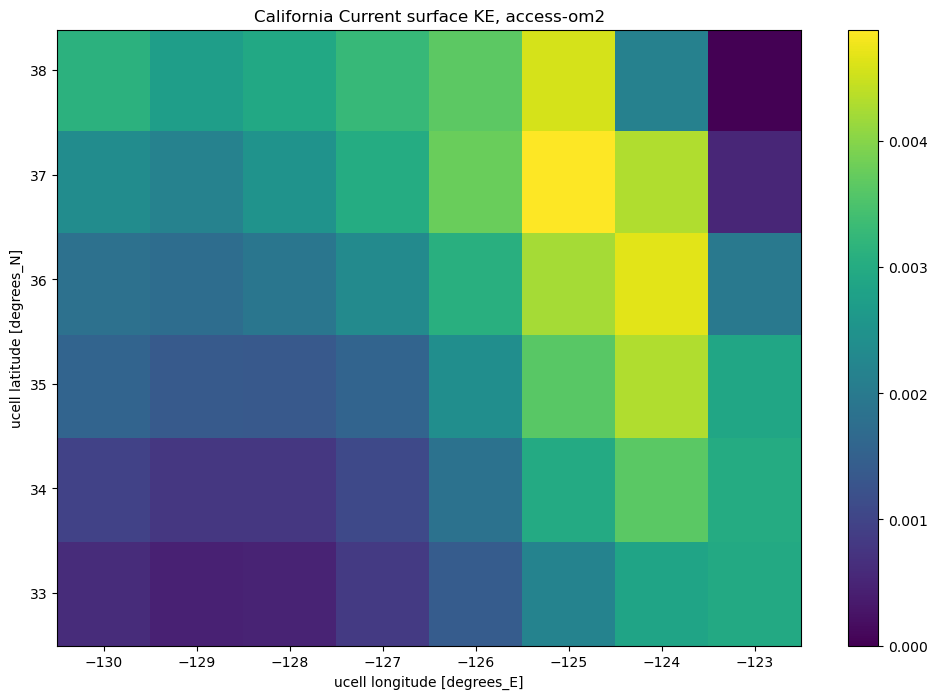

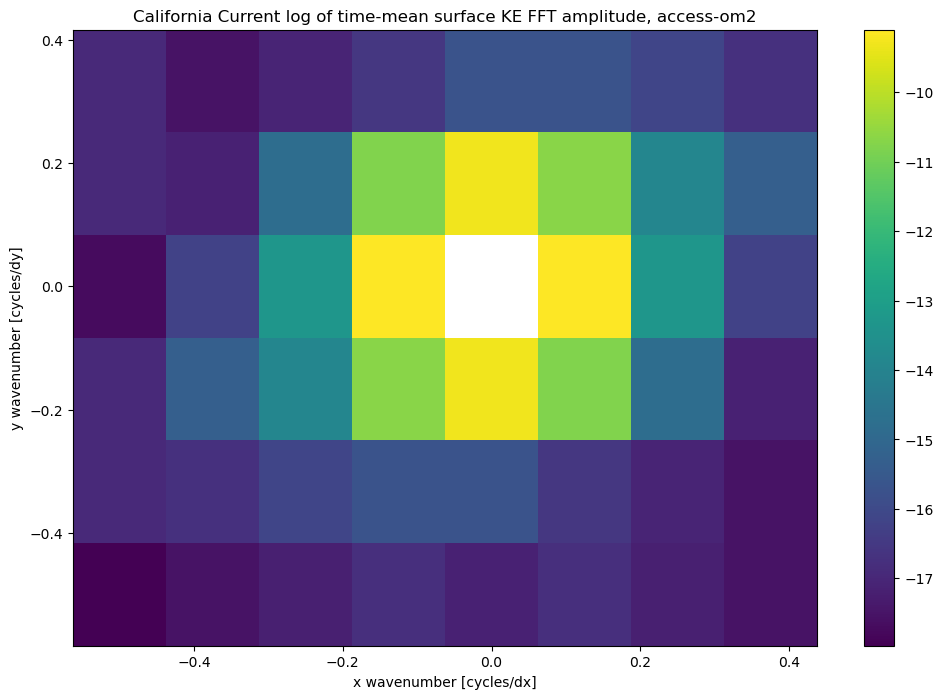

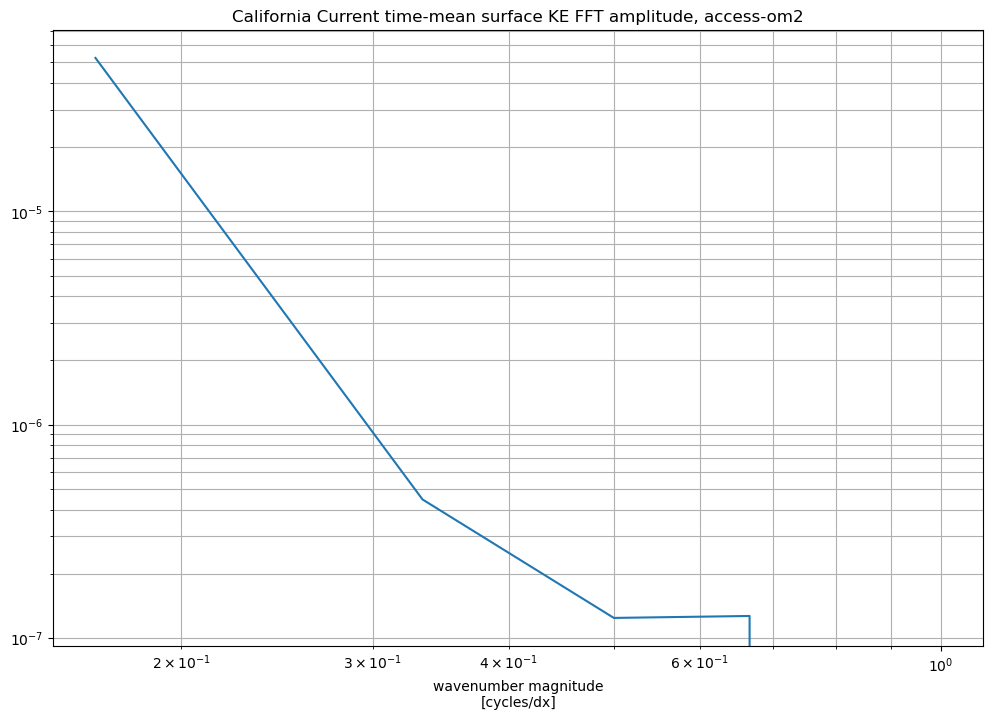

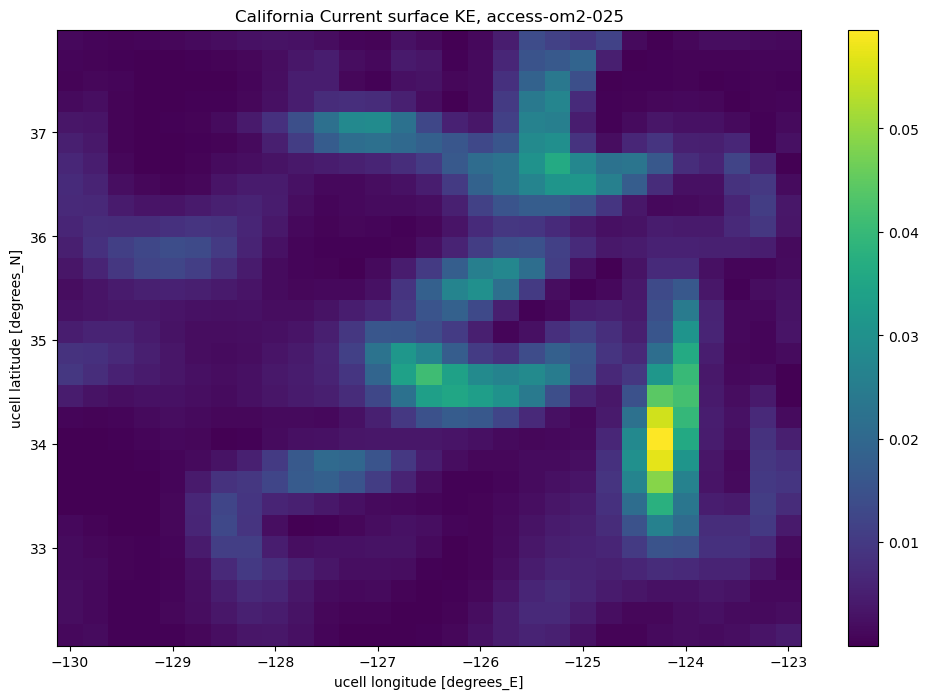

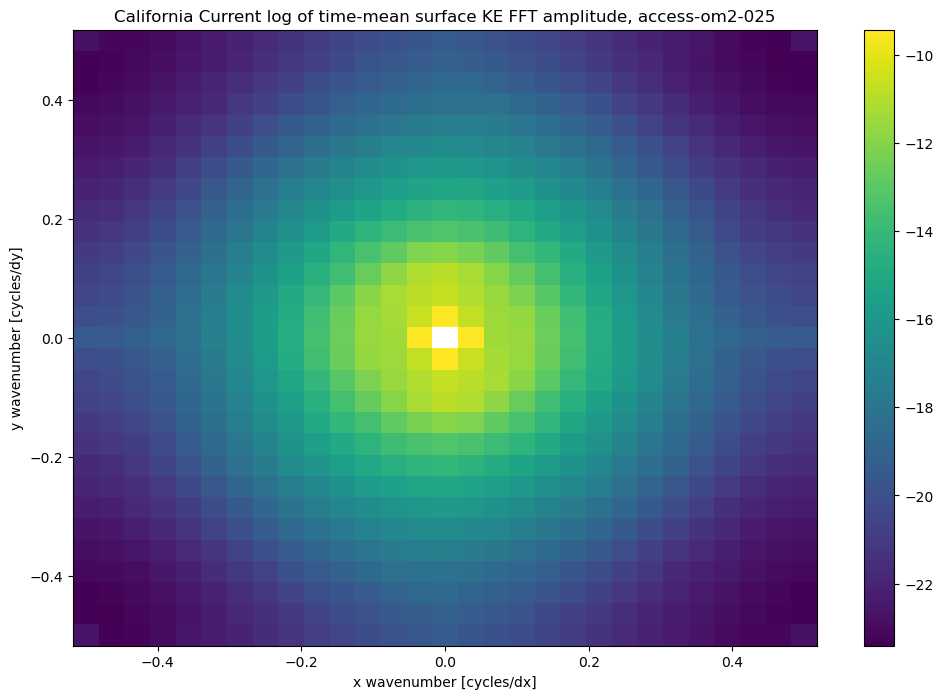

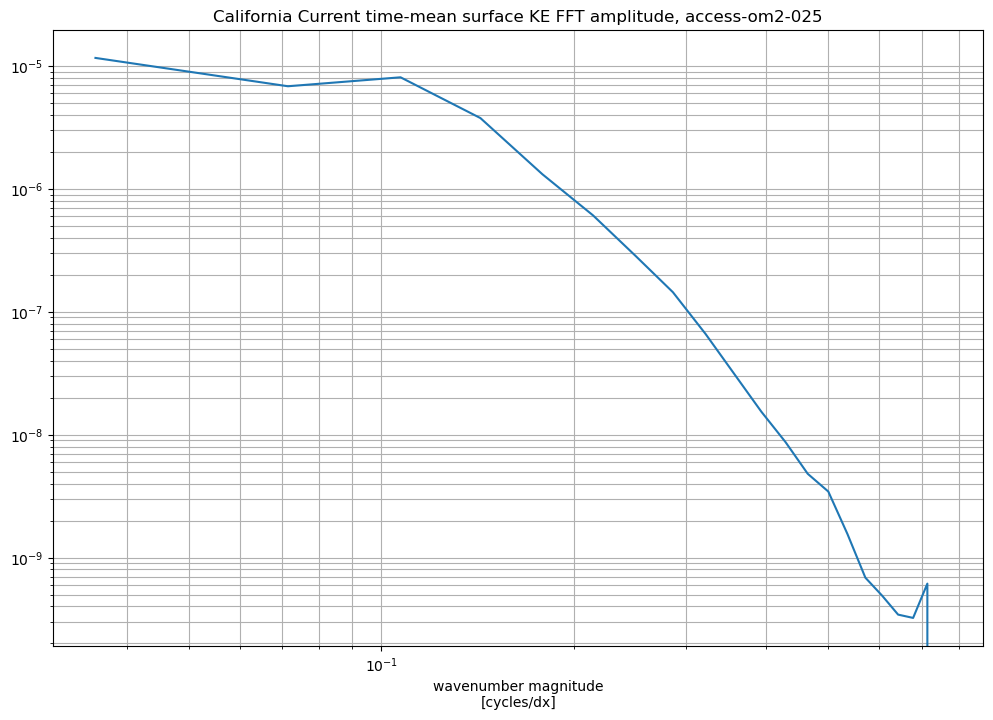

In [18]:
for locname,loc in locations.items():
    for ekey in kes.keys():
        ke = kes[ekey]['ke'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))
        u = kes[ekey]['u'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))
        v = kes[ekey]['v'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))

        fig = plt.figure(figsize=(12,8))
        ke.isel(time=0).plot()
        plt.title(locname+' surface KE, '+kes[ekey]['model'])

#         kefft = fftgrid(ke)   # incorrect
        kefft = fftgrid(u)+fftgrid(v)  # following DurranWeynMenchaca2017a eq (24)

        fig2 = plt.figure(figsize=(12,8))
        np.log(kefft).plot()  # xlim=(-0.05,0.05),ylim=(-0.05,0.05))
        plt.title(locname+' log of time-mean surface KE FFT amplitude, '+kes[ekey]['model'])

        kefftradial = azimuthal_sum(kefft)
        fig2 = plt.figure(figsize=(12,8))
        kefftradial.plot(xscale='log', yscale='log')
        plt.grid(which='both', axis='both')
        plt.title(locname+' time-mean surface KE FFT amplitude, '+kes[ekey]['model'])

## Surface enstrophy spectra

In [22]:
# load model surface vorticity snapshots
ekey = '01deg'
cat_subset = catalog['01deg_jra55v13_iaf']
var_search = cat_subset.search(variable='vorticity_z', frequency='1 monthly')
darray = var_search.to_dask()
darray = darray['vorticity_z']
vort = darray.isel(st_ocean=0)
vort = vort.fillna(0.0) # fill and with zeros

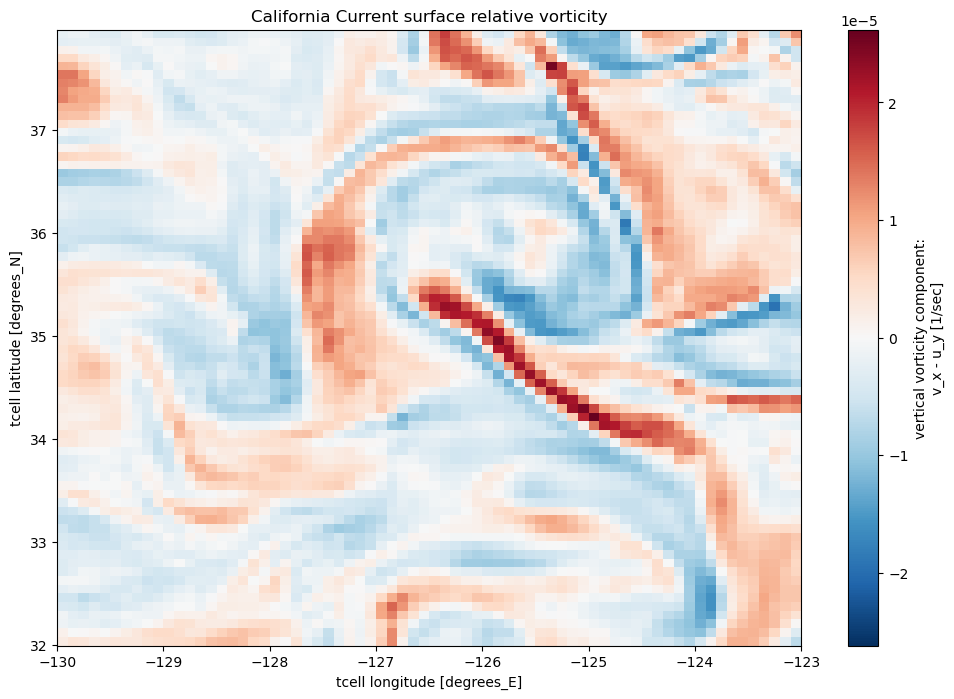

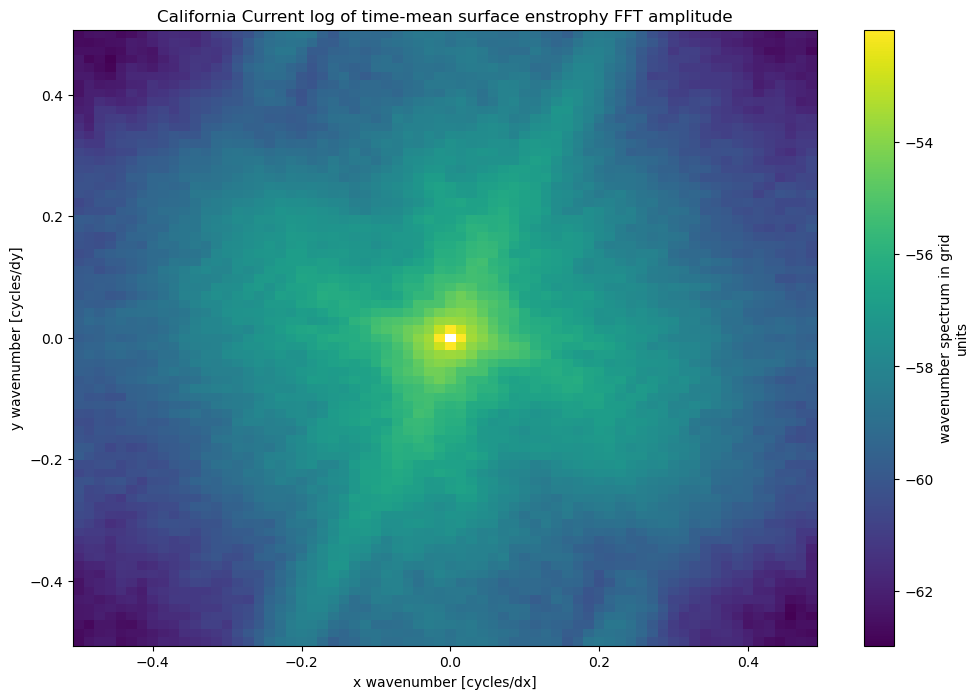

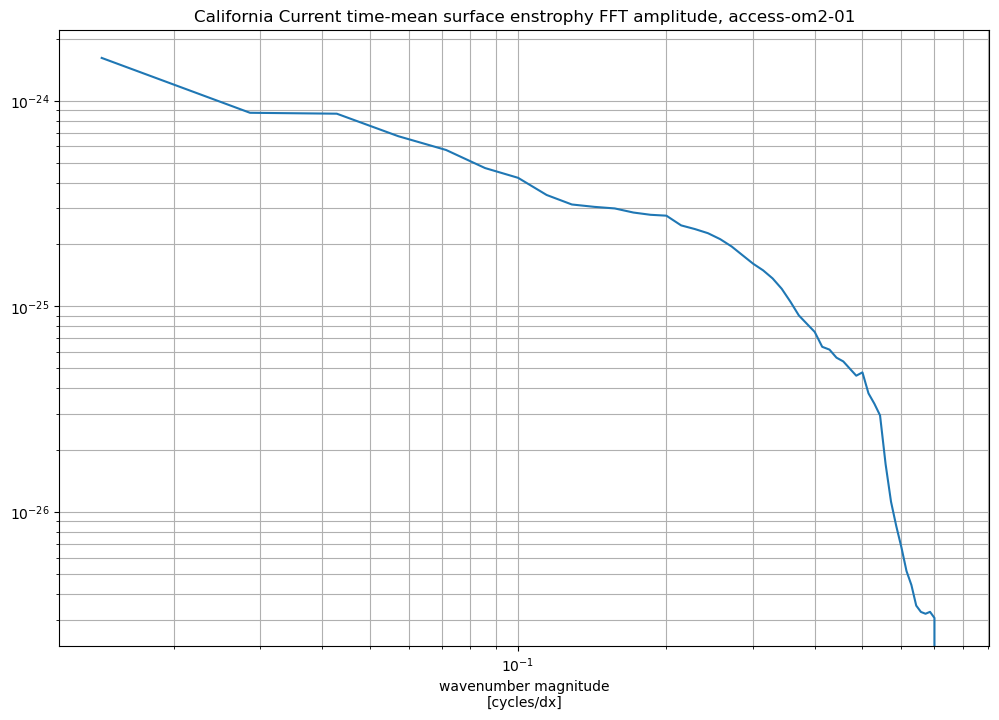

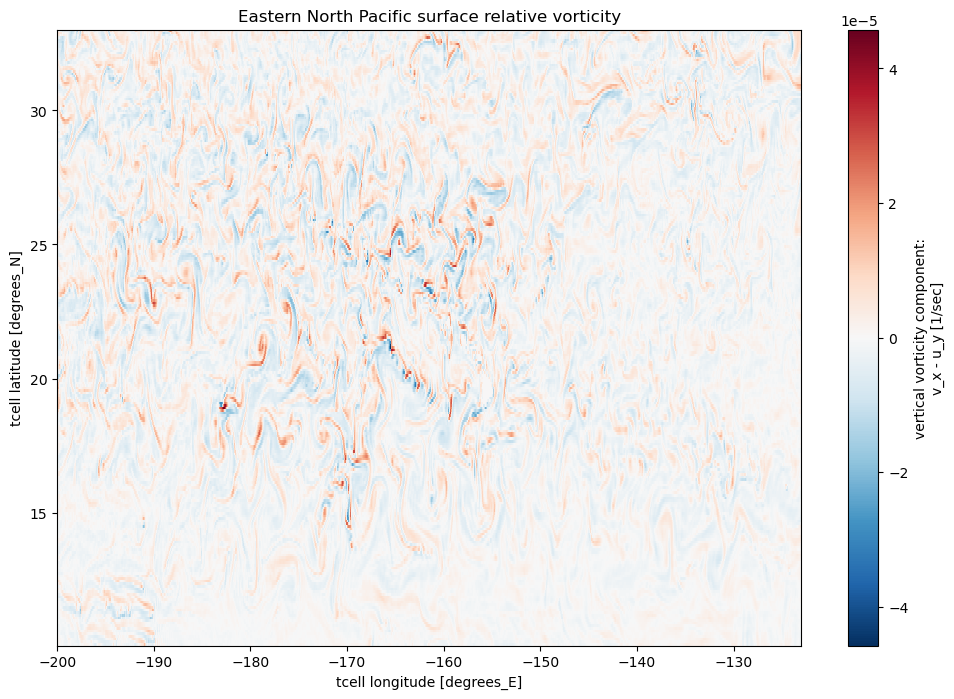

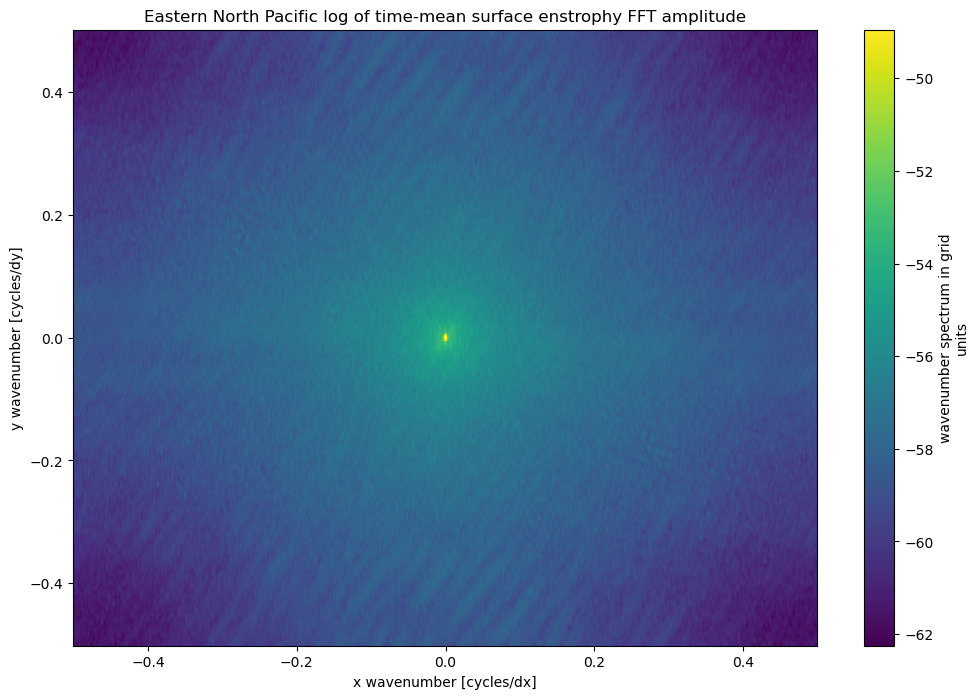

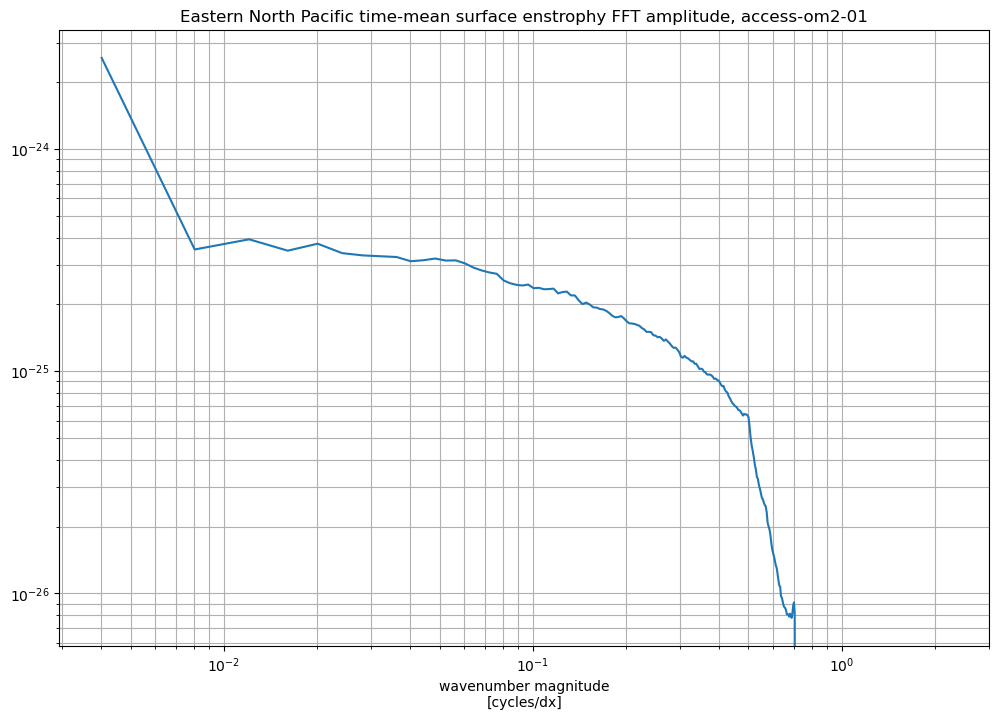

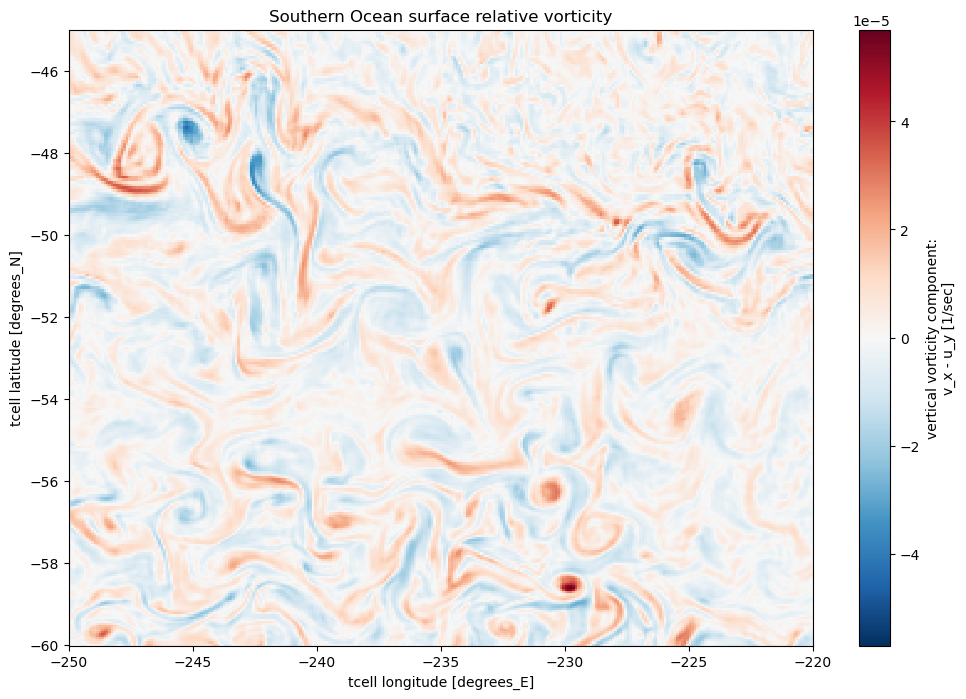

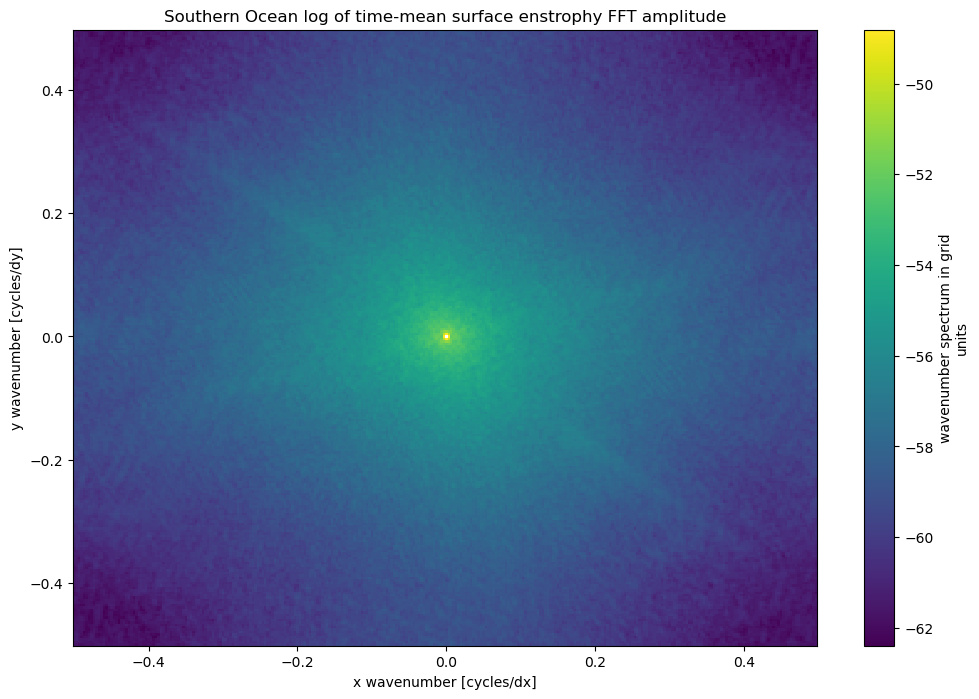

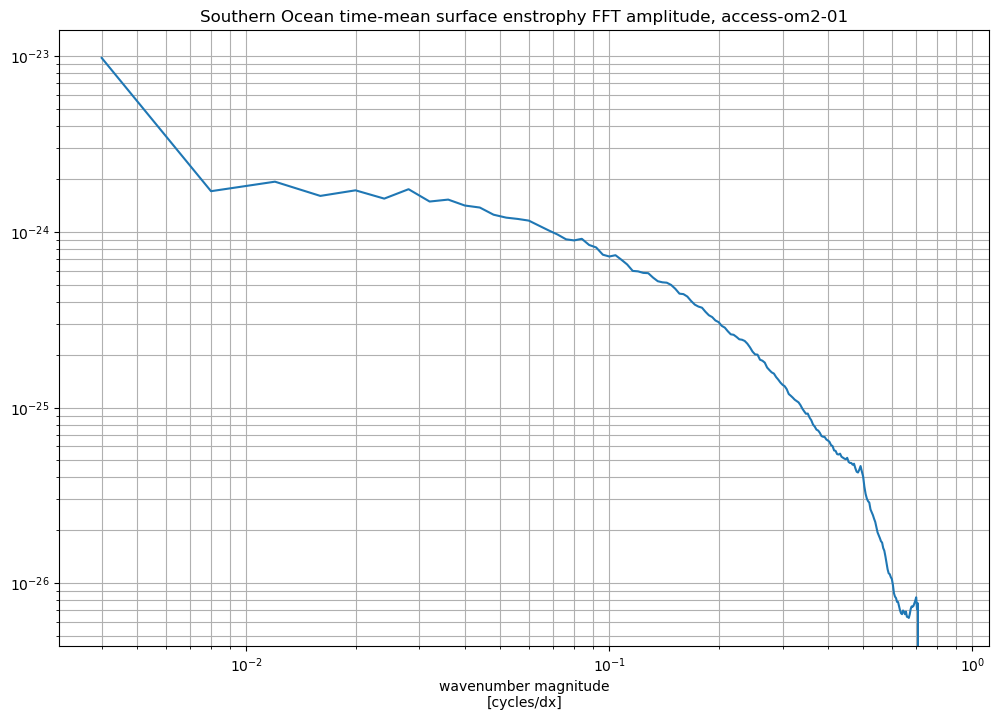

In [23]:
for locname,loc in locations.items():
    v = vort.sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
#     tdim, ydim, xdim = v.dims  # abstract out dimension names - NB: assumes this order of dimensions
#     nx = v[xdim].size
#     ny = v[ydim].size

    fig = plt.figure(figsize=(12,8))
    v.isel(time=0).plot()
    plt.title(locname+' surface relative vorticity')

    v2 = v**2
# #     fig = plt.figure(figsize=(12,8))
# #     v2.isel(time=0).plot()
# #     plt.title(locname+' surface enstrophy')

    v2dtfft = fftgrid(v2)

    fig2 = plt.figure(figsize=(12,8))
    np.log(v2dtfft).plot()  # xlim=(-0.05,0.05),ylim=(-0.05,0.05))
    plt.title(locname+' log of time-mean surface enstrophy FFT amplitude')

    v2dtfftradial = azimuthal_sum(v2dtfft)
    fig2 = plt.figure(figsize=(12,8))
    v2dtfftradial.plot(xscale='log', yscale='log')
    plt.grid(which='both', axis='both')
    plt.title(locname+' time-mean surface enstrophy FFT amplitude, '+kes[ekey]['model'])
#     break

# TODO
- first test with dummy data with known spectral content
- interpolate onto grid in units of metres (choose a power of 2)
- remove trends from interpolated data - see Errico1985a http://dx.doi.org/10.1175/1520-0493(1985)113<1554:SCFALA>2.0.CO;2
- remove mean (do this with interpolated data so it is area-weighted)
- 2d FFT
- calc squared magnitude
- convert to spectrum wrt |k| - see DurranWeynMenchaca2017a http://dx.doi.org/10.1175/MWR-D-17-0056.1
